## Simple examples

In [ ]:
from sklearn.cluster import SpectralClustering

import numpy as np
X = np.array([
    [1, 1], [2, 1], [1, 0], [4, 7], [3, 5], [3, 6]
])

clustering = SpectralClustering(
    n_clusters=2,
    assign_labels="discretize",
    random_state=0
).fit(X)
clustering.labels_

array([1, 1, 1, 0, 0, 0])

In [ ]:
X = np.array([
    [1, 2, 3],
    [2, 3, 4],
    [3, 4, 5],
])

clustering = SpectralClustering(
    n_clusters=2,
    random_state=0,
    assign_labels="discretize",
    affinity='precomputed'
).fit(X)
clustering.labels_

array([1, 0, 0])

## Playing with text data

In [ ]:
import tensorflow_hub as hub
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

In [ ]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')

print(newsgroups_train.data[0])

INFO:sklearn.datasets._twenty_newsgroups:Downloading 20news dataset. This may take a few minutes.
INFO:sklearn.datasets._twenty_newsgroups:Downloading dataset from https://ndownloader.figshare.com/files/5975967 (14 MB)


From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [ ]:
from tqdm import tqdm
import numpy as np

embeddings = []

for t in tqdm(newsgroups_train.data):
    emb = embed([t])
    embeddings.append(emb.numpy())

100%|██████████| 11314/11314 [01:05<00:00, 172.44it/s]


In [ ]:
from sklearn.decomposition import PCA

vectors = np.concatenate(embeddings)
pca = PCA(n_components=None)
vectors_pca = pca.fit_transform(vectors)
n = sum(np.cumsum(pca.explained_variance_ratio_) < 0.95)
np.sum(pca.explained_variance_ratio_[:n+1])
vectors_pca = vectors_pca[:, :n+1]

In [ ]:
clustering = SpectralClustering(
    n_clusters=len(newsgroups_train.target_names),
    assign_labels="discretize",
    random_state=0
).fit(vectors_pca)
clustering.labels_

array([11,  4, 11, ...,  4, 10,  3])

In [ ]:
newsgroups_train.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

1) check clusterization quality based on b-cubed

2) find and read the article that descirbes 'assign_labels="discretize"' params [optionally]

3) do we need pca at all? [optionally]

### 1. B-cubed metric for clusterization quality.

In [11]:
# Take implementation for bcubed.
!pip install bcubed

# Source: https://github.com/hhromic/python-bcubed

In [80]:
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
import bcubed
import time

In [ ]:
# Dataset description.
print(newsgroups_train.DESCR)

In [45]:
# Function for computing BCubed metrics for clusterization.

def compute_bcubed(gold_lst, predicted_lst):
    """
    Takes gold standard, predicted.
    Returns recall, precision, f1score
    """
    gold = {i: {cluster} for i, cluster in enumerate(gold_lst)}
    pred = {i: {cluster} for i, cluster in enumerate(predicted_lst)}
    precision = bcubed.precision(pred, gold)
    recall = bcubed.recall(pred, gold)
    f_score = bcubed.fscore(precision, recall)
    return precision, recall, f_score

# https://github.com/hhromic/python-bcubed/blob/master/example.py
# https://python.hotexamples.com/examples/bcubed/-/precision/python-precision-function-examples.html

In [46]:
le = LabelEncoder()
y_true = le.fit_transform(newsgroups_train.target)

y_pred = clustering.labels_
# f1 = f1_score(y_pred, y_true, average='macro')
f1 = f1_score(y_pred, newsgroups_train.target, average='macro')
precision_bc, recall_bc, f_bc = compute_bcubed(newsgroups_train.target, y_pred)
print('F1-score: {:.3f}'.format(f1))
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f},'.format(precision_bc, recall_bc, f_bc))

F1-score: 0.067
Precision-BCubed: 0.400, Recall-BCubed: 0.376, F-BCubed: 0.388,


In [20]:
# Loading test dataset
newsgroups_test = fetch_20newsgroups(subset='test')

In [48]:
# Do all the transforamtions for the test dataset as for the training one.
embeddings_test = []

for t in tqdm(newsgroups_test.data):
    emb = embed([t])
    embeddings_test.append(emb.numpy())

vectors_te = np.concatenate(embeddings_test)
vectors_pca_te = pca.transform(vectors_te)
vectors_pca_te = vectors_pca_te[:, :n+1]

100%|██████████| 7532/7532 [00:41<00:00, 181.05it/s]


In [49]:
# Predictions for test dataset.
pred_test = clustering.fit_predict(vectors_pca_te)
pred_test

array([12, 14,  7, ...,  4,  0,  7])

In [50]:
f1 = f1_score(pred_test, newsgroups_test.target, average='macro')
precision_bc, recall_bc, f_bc = compute_bcubed(newsgroups_test.target, pred_test)
print('Test dataset')
print('F1-score: {:.3f}'.format(f1))
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f},'.format(precision_bc, recall_bc, f_bc))

Test dataset
F1-score: 0.021
Precision-BCubed: 0.424, Recall-BCubed: 0.415, F-BCubed: 0.419,


Bcubed metric reflects the quality of the unsupervised clustering algorithm better than traditional f1-metric used for classification tasks. This is due to the nature of the ML problem. Bcubed looks at the quality inside each cluster (by precision: homogeneity inside each cluster) and at the quality with respect to the true labels (by recall: homogeneity between clusters), so it looks at overall quality, while the traditional f1-measure looks at each specific label and in certain sense does not take into account clusterization.

### 2. Assigning labels with "discretize" strategy.

In [57]:
# Discretization strategy.
start = time.time()
c_discretize = SpectralClustering(
    n_clusters=len(newsgroups_train.target_names),
    assign_labels="discretize",
    random_state=0
).fit(vectors_pca)
end = time.time()
time_d = end - start
pred_d = c_discretize.labels_

# K-means strategy.
start_ = time.time()
c_kmeans = SpectralClustering(
    n_clusters=len(newsgroups_train.target_names),
    assign_labels="kmeans",
    random_state=0
).fit(vectors_pca)
end_ = time.time()
time_k = end_ - start_
pred_k = c_kmeans.labels_

pr_d, rec_d, bcubed_d = compute_bcubed(newsgroups_train.target, pred_d)
pr_k, rec_k, bcubed_k = compute_bcubed(newsgroups_train.target, pred_k)

In [69]:
print('Train')
print('===============================================================')
print('Discretize strategy')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_d, rec_d, bcubed_d))
print('Time {:.5f}'.format(time_d / 60))
print('===============================================================')

print('K-means strategy')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_k, rec_k, bcubed_k))
print('Time {:.5f}'.format(time_k / 60))
print('===============================================================')

Train
Discretize strategy
Precision-BCubed: 0.400, Recall-BCubed: 0.376, F-BCubed: 0.388
Time 1.01715
K-means strategy
Precision-BCubed: 0.421, Recall-BCubed: 0.460, F-BCubed: 0.439
Time 1.01172


In [65]:
start = time.time()
pred_d_te = c_discretize.fit_predict(vectors_pca_te)
end = time.time()
time_d_te = end - start

start_ = time.time()
pred_k_te = c_kmeans.fit_predict(vectors_pca_te)
end_ = time.time()
time_k_te = end_ - start_

pr_d_te, rec_d_te, bcubed_d_te = compute_bcubed(newsgroups_test.target, pred_d_te)
pr_k_te, rec_k_te, bcubed_k_te = compute_bcubed(newsgroups_test.target, pred_k_te)

In [70]:
print('Test')
print('===============================================================')
print('Discretize strategy')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_d_te, rec_d_te, bcubed_d_te))
print('Time: {:.5f}'.format(time_d_te / 60))
print('===============================================================')

print('K-means strategy')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_k_te, rec_k_te, bcubed_k_te))
print('Time: {:.5f}'.format(time_k_te / 60))
print('===============================================================')

Test
Discretize strategy
Precision-BCubed: 0.424, Recall-BCubed: 0.415, F-BCubed: 0.419
Time: 0.35306
K-means strategy
Precision-BCubed: 0.411, Recall-BCubed: 0.443, F-BCubed: 0.427
Time: 0.39861


For this dataset **k-means strategy of labels assigning works better that discretize strategy**.
Let's recall the spectral clustering algorithm:
1. Construct a graph G from the objects and compute its Laplacian L.
2. Find normalized eigenvectors of L for m smallest eigenvalues.
3. Create a matrix U from eigenvectors.
4. Apply algorithm for dividing objects into clusters (usually k-means).

Thus, after the third step we get the new embedding space for the objects and there are several ways to clusterize them in this new embedding space. In sklearn realization there are two ways to assign labels after the Laplacian embedding: 
* k-means;
* discretization.

K-means is a popular choice, but it has disadvantage: it can be sensitive to the initialization (k-means takes random values for the clusters centers as their first initialization). **While discretization is less sensitive to random initialization. Another advantage of the discretization algorithm is its faster convergence compared to other clustering methods as authors claim.** However, for the given dataset the time of training for both strategies is almost the same (for test dataset discretization works faster than k-means).


**Algorithm of spectral clustering with discretization strategy from the [article](https://www1.icsi.berkeley.edu/~stellayu/publication/doc/2003kwayICCV.pdf):**

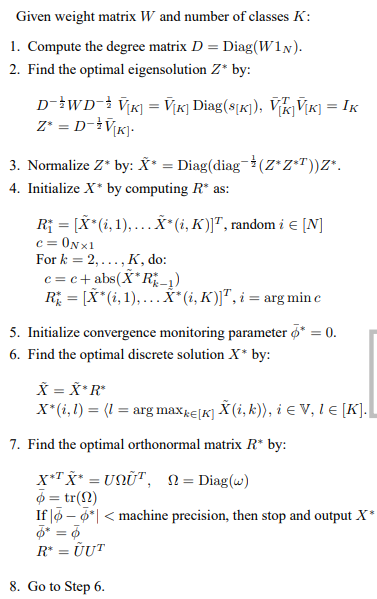

So after obtaining the Laplacian embeddings we try to discretize them (starting from the 4th step). Basically, there are 2 steps: 
* at **the first step** a relaxed *continuous* optimization problem is solved. The global optima are given by some eigenvectors subject to arbitrary orthonormal transform (X* inititalization at the step 4);
* at **the second step** we solve for a *discrete* solution that is closest to the continuous optima using an alternating optimization procedure. We alternate
the following: the continuous optimum closest to a discrete solution is located by computing the best orthonormal transform R*, and the discrete solution closest to a continuous one is located by non-maximum suppression (steps 6, 7). 

Then finding optimal discrete solution and finding optimal orthonormal matrix  are iteratively repeated to get closer to the global optimal solution (repeat steps 6, 7). As the result, the distance between a discrete solution and the continuous optima is decreased. After convergence, a nearly global-optimal partitioning is obtained.

### 3. Whether spectral clustering works better with PCA or without.
As we apply PCA we move into the lower dimensional space, so we expect that algorithm should work faster with PCA.

In [81]:
# Without PCA
start = time.time()
clustering = SpectralClustering(
    n_clusters=len(newsgroups_train.target_names),
    assign_labels="discretize",
    random_state=0
).fit(vectors)
end = time.time()
time_without = end - start
pred = clustering.labels_

# With PCA
start_ = time.time()
clustering_pca = SpectralClustering(
    n_clusters=len(newsgroups_train.target_names),
    assign_labels="discretize",
    random_state=0
).fit(vectors_pca)
end_ = time.time()
time_pca = end_ - start_
pred_pca = clustering_pca.labels_

pr_, rec_, bcubed_ = compute_bcubed(newsgroups_train.target, pred)
pr_pca, rec_pca, bcubed_pca = compute_bcubed(newsgroups_train.target, pred_pca)

In [83]:
print('Train')
print('===============================================================')
print('Without PCA')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_, rec_, bcubed_))
print('Time {:.5f}'.format(time_without / 60))
print('===============================================================')

print('With PCA')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_pca, rec_pca, bcubed_pca))
print('Time {:.5f}'.format(time_pca / 60))
print('===============================================================')

Train
Without PCA
Precision-BCubed: 0.431, Recall-BCubed: 0.419, F-BCubed: 0.425
Time 1.02556
With PCA
Precision-BCubed: 0.400, Recall-BCubed: 0.376, F-BCubed: 0.388
Time 1.01238


In [86]:
start = time.time()
pred_without_te = clustering.fit_predict(vectors_te)
end = time.time()
time_without_te = end - start

start_ = time.time()
pred_pca_te = clustering_pca.fit_predict(vectors_pca_te)
end_ = time.time()
time_pca_te = end_ - start_

pr_without_te, rec_without_te, bcubed_without_te = compute_bcubed(newsgroups_test.target, pred_without_te)
pr_pca_te, rec_pca_te, bcubed_pca_te = compute_bcubed(newsgroups_test.target, pred_pca_te)

In [88]:
print('Test')
print('===============================================================')
print('Without PCA')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_without_te, rec_without_te, bcubed_without_te))
print('Time {:.5f}'.format(time_without_te / 60))
print('===============================================================')

print('With PCA')
print('Precision-BCubed: {:.3f}, Recall-BCubed: {:.3f}, F-BCubed: {:.3f}'.format(pr_pca_te, rec_pca_te, bcubed_pca_te))
print('Time {:.5f}'.format(time_pca_te / 60))
print('===============================================================')

Test
Without PCA
Precision-BCubed: 0.416, Recall-BCubed: 0.419, F-BCubed: 0.417
Time 0.34980
With PCA
Precision-BCubed: 0.424, Recall-BCubed: 0.415, F-BCubed: 0.419
Time 0.31528


As expected it takes longer to clusterize objects using initial vector space with all features than using smaller number of PCA-transformed features. In addition, PCA does not lose much information from the data as metric of quality with PCA is comparable with metric without PCA (for test BCubed is even higher with PCA than without it, but for training dataset the quality of model decreased with using PCA). So we need PCA as long as it decreases the training time and gives commensurable results.